In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from flask import Flask, request, render_template_string, session

In [2]:
df = pd.read_csv("data_finish.csv")


In [3]:
df.head()

,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id,station_name,region_name,flood
0,2016-01-01,26.0,34.8,28.6,81.0,NaN,5.8,5.0,280.0,2.0,S,96733,Stasiun Klimatologi Banten,Jakarta Selatan,0
1,2016-01-02,25.6,33.2,27.0,88.0,1.6,8.7,4.0,290.0,2.0,W,96733,Stasiun Klimatologi Banten,Jakarta Selatan,1
2,2016-01-03,24.4,34.9,28.1,80.0,33.8,5.4,4.0,280.0,2.0,SW,96733,Stasiun Klimatologi Banten,Jakarta Selatan,1
3,2016-01-04,24.8,33.6,29.2,81.0,NaN,6.6,3.0,200.0,1.0,S,96733,Stasiun Klimatologi Banten,Jakarta Selatan,0
4,2016-01-05,25.8,33.6,26.7,91.0,NaN,3.2,3.0,180.0,1.0,S,96733,Stasiun Klimatologi Banten,Jakarta Selatan,0


In [4]:
df = df.drop(columns=['Tn', 'Tx', 'ss', 'ddd_x', 'ff_x', 'station_id', 'station_name'], axis=1)

In [5]:
print(df.head())
df.info()

         date  Tavg  RH_avg    RR  ff_avg ddd_car      region_name  flood
0  2016-01-01  28.6    81.0   NaN     2.0      S   Jakarta Selatan      0
1  2016-01-02  27.0    88.0   1.6     2.0      W   Jakarta Selatan      1
2  2016-01-03  28.1    80.0  33.8     2.0      SW  Jakarta Selatan      1
3  2016-01-04  29.2    81.0   NaN     1.0      S   Jakarta Selatan      0
4  2016-01-05  26.7    91.0   NaN     1.0      S   Jakarta Selatan      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6308 non-null   object 
 1   Tavg         6262 non-null   float64
 2   RH_avg       6256 non-null   float64
 3   RR           3993 non-null   float64
 4   ff_avg       6215 non-null   float64
 5   ddd_car      6207 non-null   object 
 6   region_name  6308 non-null   object 
 7   flood        6308 non-null   int64  
dtypes: float64(4), int64(1), 

In [6]:
df.isnull().sum()

date              0
Tavg             46
RH_avg           52
RR             2315
ff_avg           93
ddd_car         101
region_name       0
flood             0
dtype: int64

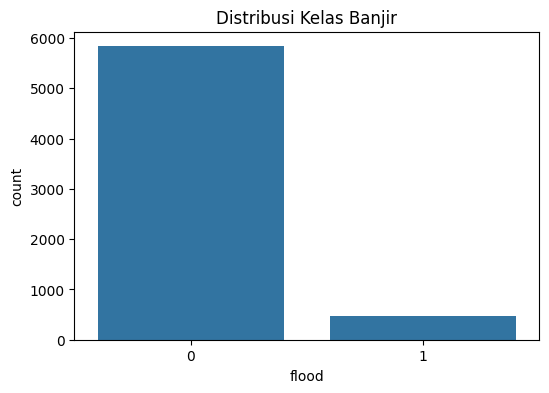

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='flood', data=df)
plt.title('Distribusi Kelas Banjir')
plt.show()

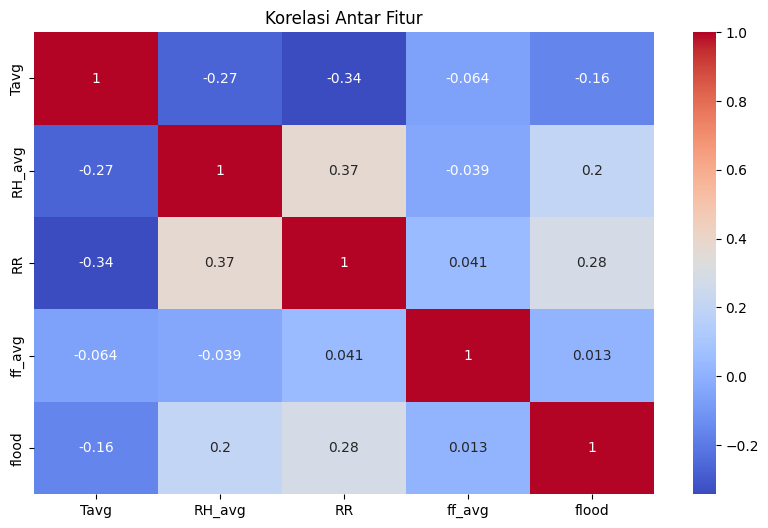

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

In [9]:
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(f"\nColumns with missing values before imputation: {cols_with_missing}")

numerical_cols_with_missing = df.select_dtypes(include=np.number).columns[df.select_dtypes(include=np.number).isnull().any()].tolist()
if numerical_cols_with_missing:
    imputer_mean = SimpleImputer(strategy='mean')
    df[numerical_cols_with_missing] = imputer_mean.fit_transform(df[numerical_cols_with_missing])
    print(f"Imputed numerical missing values with mean for: {numerical_cols_with_missing}")

if 'ddd_car' in df.columns and df['ddd_car'].isnull().any():
    if df['ddd_car'].dtype == 'object' or pd.api.types.is_categorical_dtype(df['ddd_car']):
        print(f"Imputing 'ddd_car' with mode.")
        imputer_mode_ddd_car = SimpleImputer(strategy='most_frequent')
        df[['ddd_car']] = imputer_mode_ddd_car.fit_transform(df[['ddd_car']])
    else: 
        df['ddd_car'].fillna(0, inplace=True) 

categorical_cols_object_type = df.select_dtypes(include='object').columns.tolist()
other_categorical_cols_missing = [col for col in categorical_cols_object_type if col != 'ddd_car' and df[col].isnull().any()]
if other_categorical_cols_missing:
    imputer_mode_other = SimpleImputer(strategy='most_frequent')
    df[other_categorical_cols_missing] = imputer_mode_other.fit_transform(df[other_categorical_cols_missing])
    print(f"Imputed other categorical missing values with mode for: {other_categorical_cols_missing}")

print("\nMissing values after imputation stage:")
print(df.isnull().sum())

# Feature Engineering (Date)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    print("\nEngineered date features.")
    df = df.drop('date', axis=1)

# Encoding Categorical Features
label_encoders_global = {} # To store encoders from the main script's preprocessing
categorical_cols_to_encode = df.select_dtypes(include='object').columns.tolist()
# Ensure 'flood' is not in this list if it's object and target
if 'flood' in categorical_cols_to_encode and df['flood'].dtype == 'object':
    categorical_cols_to_encode.remove('flood')

print(f"\nCategorical columns for encoding: {categorical_cols_to_encode}")
for col in categorical_cols_to_encode:
    label_encoders_global[col] = LabelEncoder()
    df[col] = label_encoders_global[col].fit_transform(df[col].astype(str)) # Ensure string type before encoding
    print(f"Applied Label Encoding to: {col}. Classes: {list(label_encoders_global[col].classes_)}")

print("\nDataFrame after full preprocessing (head):")
print(df.head())
print("\nData types after full preprocessing:")
df.info()


Columns with missing values before imputation: ['Tavg', 'RH_avg', 'RR', 'ff_avg', 'ddd_car']
Imputed numerical missing values with mean for: ['Tavg', 'RH_avg', 'RR', 'ff_avg']
Imputing 'ddd_car' with mode.

Missing values after imputation stage:
date           0
Tavg           0
RH_avg         0
RR             0
ff_avg         0
ddd_car        0
region_name    0
flood          0
dtype: int64

Engineered date features.

Categorical columns for encoding: ['ddd_car', 'region_name']
Applied Label Encoding to: ddd_car. Classes: ['C ', 'E ', 'N ', 'NE', 'NW', 'S ', 'SE', 'SW', 'W ']
Applied Label Encoding to: region_name. Classes: ['Jakarta Pusat', 'Jakarta Selatan', 'Jakarta Timur', 'Jakarta Utara']

DataFrame after full preprocessing (head):
   Tavg  RH_avg         RR  ff_avg  ddd_car  region_name  flood  year  month  \
0  28.6    81.0   9.415502     2.0        5            1      0  2016      1   
1  27.0    88.0   1.600000     2.0        8            1      1  2016      1   
2  28.1    

In [10]:
X = df.drop(columns=['flood'])
y = df['flood']

# Check feature names that will be used for training
print(f"\nFeatures for model training (X columns): {X.columns.tolist()}")
print(f"Number of features for model training: {X.shape[1]}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

try:
    from imblearn.over_sampling import SMOTE
    print("\nimblearn found.")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print(f"Resampled training dataset shape: {X_resampled.shape}")

    model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
    model_smote.fit(X_resampled, y_resampled)
    print(f"\nModel trained with SMOTE. It expects {model_smote.n_features_in_} features.")

    y_pred_smote = model_smote.predict(X_test)
    print("\n--- Evaluation after SMOTE (on original test set) ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))

    with open('model_smote.pkl', 'wb') as f:
        pickle.dump(model_smote, f)
        print("\nModel trained on SMOTE data saved as 'model_smote.pkl'")

except ImportError:
    print("imblearn not found.")
    model_smote = RandomForestClassifier(n_estimators=100, random_state=42) # Re-initialize
    model_smote.fit(X_train, y_train)
    print(f"\nModel trained WITHOUT SMOTE (imblearn not found). It expects {model_smote.n_features_in_} features.")
    y_pred_no_smote = model_smote.predict(X_test)
    print("\n--- Evaluation WITHOUT SMOTE (on original test set) ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_no_smote))
    print("\nClassification Report:\n", classification_report(y_test, y_pred_no_smote))
    with open('model_smote.pkl', 'wb') as f: # Still save as model_smote.pkl for consistency
        pickle.dump(model_smote, f)
        print("\nModel trained WITHOUT SMOTE data saved as 'model_smote.pkl'")



Features for model training (X columns): ['Tavg', 'RH_avg', 'RR', 'ff_avg', 'ddd_car', 'region_name', 'year', 'month', 'day', 'dayofweek']
Number of features for model training: 10

imblearn found.
Resampled training dataset shape: (9330, 10)

Model trained with SMOTE. It expects 10 features.

--- Evaluation after SMOTE (on original test set) ---
Confusion Matrix:
 [[1110   57]
 [  76   19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1167
           1       0.25      0.20      0.22        95

    accuracy                           0.89      1262
   macro avg       0.59      0.58      0.58      1262
weighted avg       0.88      0.89      0.89      1262


Model trained on SMOTE data saved as 'model_smote.pkl'


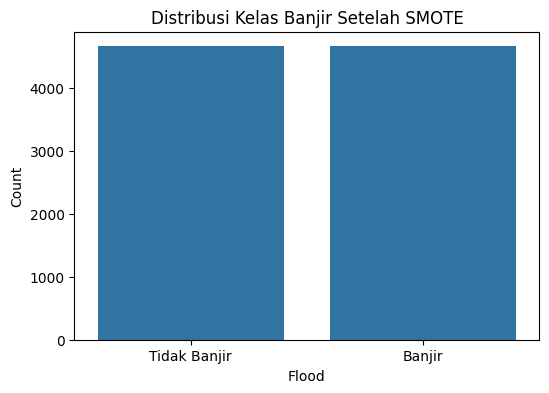

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled)
plt.title('Distribusi Kelas Banjir Setelah SMOTE')
plt.xlabel('Flood')
plt.ylabel('Count')
plt.xticks([0, 1], ['Tidak Banjir', 'Banjir'])
plt.show()

In [12]:

app = Flask(__name__)
app.secret_key = 'your_very_secret_key_for_sessions_ddd_car'

model_flask = None
X_FEATURES_ORDER_FLASK = []
DEFAULT_FEATURE_VALUES_FLASK = {}
LABEL_ENCODERS_FLASK = {}

def load_model_and_defaults_flask():
    global model_flask, X_FEATURES_ORDER_FLASK, DEFAULT_FEATURE_VALUES_FLASK, LABEL_ENCODERS_FLASK
    model_path = 'model_smote.pkl' # This model will now expect 10 features

    # These are the 10 features the model is expected to be trained on
    X_FEATURES_ORDER_FLASK = [
        'Tavg', 'RH_avg', 'RR', 'ff_avg',
        'ddd_car', 
        'region_name',
        'year', 'month', 'day', 'dayofweek'
    ]
    print(f"Flask: App expects model to use {len(X_FEATURES_ORDER_FLASK)} features in this order: {X_FEATURES_ORDER_FLASK}")

    try:
        with open(model_path, 'rb') as f:
            model_flask = pickle.load(f)
        print(f"Flask: Model '{model_path}' loaded. Model was trained with {model_flask.n_features_in_} features.")
        if model_flask.n_features_in_ != len(X_FEATURES_ORDER_FLASK):
            print(f"Flask CRITICAL WARNING: Model feature count ({model_flask.n_features_in_}) "
                  f"does NOT match X_FEATURES_ORDER_FLASK count ({len(X_FEATURES_ORDER_FLASK)}). "
                  "This WILL cause errors. Ensure the loaded model was trained with ddd_car.")
    except FileNotFoundError:
        print(f"Flask ERROR: Model file '{model_path}' not found. Please train and save the model first.")
        return False
    except Exception as e:
        print(f"Flask Error loading model: {e}")
        return False

    data_path = 'data_finish.csv'
    JAKARTA_REGIONS_FOR_ENCODER = ['Jakarta Barat', 'Jakarta Utara', 'Jakarta Pusat', 'Jakarta Timur', 'Jakarta Selatan']

    # Initialize LabelEncoders for Flask
    le_region_flask = LabelEncoder()
    le_region_flask.fit(JAKARTA_REGIONS_FOR_ENCODER)
    LABEL_ENCODERS_FLASK['region_name'] = le_region_flask
    print(f"Flask: Fitted LabelEncoder for region_name. Classes: {list(le_region_flask.classes_)}")

    if os.path.exists(data_path):
        df_source = pd.read_csv(data_path)
         # Drop the same initial columns as the main script to get consistent source for ddd_car
        df_source.drop(columns=['Tn', 'Tx', 'ss', 'ddd_x', 'ff_x', 'station_id', 'station_name'], axis=1, inplace=True, errors='ignore')
        print(f"Flask: '{data_path}' loaded for defaults and ddd_car processing.")

        # Impute numerical for default value calculation
        numerical_cols_for_mean_flask = ['Tavg', 'RH_avg', 'RR', 'ff_avg']
        actual_numerical_cols_for_mean_flask = [col for col in numerical_cols_for_mean_flask if col in df_source.columns]
        if actual_numerical_cols_for_mean_flask:
            imputer_mean_flask = SimpleImputer(strategy='mean')
            df_source[actual_numerical_cols_for_mean_flask] = imputer_mean_flask.fit_transform(df_source[actual_numerical_cols_for_mean_flask])

        # Process 'ddd_car' for Flask: Impute, Fit Encoder, Get Default Encoded Mode
        if 'ddd_car' in df_source.columns:
            # Impute ddd_car if it has missing values (using its mode)
            if df_source['ddd_car'].isnull().any():
                print("Flask: Imputing missing 'ddd_car' values using mode for default calculation.")
                imputer_mode_ddd_car_flask = SimpleImputer(strategy='most_frequent')
                df_source[['ddd_car']] = imputer_mode_ddd_car_flask.fit_transform(df_source[['ddd_car']])
            
            le_ddd_car_flask = LabelEncoder()
            # Fit the encoder on the unique string values of ddd_car from the source file
            ddd_car_classes = df_source['ddd_car'].astype(str).unique()
            le_ddd_car_flask.fit(ddd_car_classes)
            LABEL_ENCODERS_FLASK['ddd_car'] = le_ddd_car_flask
            
            # Get the mode of the (now imputed) string ddd_car column and encode it for the default
            default_ddd_car_str = df_source['ddd_car'].mode()[0]
            DEFAULT_FEATURE_VALUES_FLASK['ddd_car'] = le_ddd_car_flask.transform([default_ddd_car_str])[0]
            print(f"Flask: Fitted LabelEncoder for ddd_car. Classes: {list(le_ddd_car_flask.classes_)}")
            print(f"Flask: Default encoded ddd_car: {DEFAULT_FEATURE_VALUES_FLASK['ddd_car']} (from mode '{default_ddd_car_str}')")
        else:
            print("Flask ERROR: 'ddd_car' column not found in source data for setting up encoder and default. Predictions will likely fail.")
            # Fallback if ddd_car isn't in df_source (should not happen)
            # This part is risky as classes might not match training
            fallback_ddd_car_classes = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'C'] # Example
            le_ddd_car_flask = LabelEncoder()
            le_ddd_car_flask.fit(fallback_ddd_car_classes)
            LABEL_ENCODERS_FLASK['ddd_car'] = le_ddd_car_flask
            DEFAULT_FEATURE_VALUES_FLASK['ddd_car'] = 0 # Default to first encoded class
            print(f"Flask WARNING: Using fallback for ddd_car encoding and default value.")


        DEFAULT_FEATURE_VALUES_FLASK.update({
            'Tavg': df_source['Tavg'].mean() if 'Tavg' in actual_numerical_cols_for_mean_flask else 28.0,
            'RH_avg': df_source['RH_avg'].mean() if 'RH_avg' in actual_numerical_cols_for_mean_flask else 75.0,
            'RR': df_source['RR'].mean() if 'RR' in actual_numerical_cols_for_mean_flask else 9.0,
            'ff_avg': df_source['ff_avg'].mean() if 'ff_avg' in actual_numerical_cols_for_mean_flask else 2.0,
        })
        print(f"Flask: Default numerical feature values based on '{data_path}'.")
    else: # Fallback if data_finish.csv is not found
        print(f"Flask Warning: Data file '{data_path}' not found. Using hardcoded defaults.")
        DEFAULT_FEATURE_VALUES_FLASK.update({
            'Tavg': 28.0, 'RH_avg': 75.0, 'RR': 9.0, 'ff_avg': 2.0,
        })
        # Fallback for ddd_car if data_finish.csv is missing
        if 'ddd_car' not in DEFAULT_FEATURE_VALUES_FLASK: # Check if already set by failed df_source logic
            fallback_ddd_car_classes = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'C']
            le_ddd_car_flask = LabelEncoder()
            le_ddd_car_flask.fit(fallback_ddd_car_classes)
            LABEL_ENCODERS_FLASK['ddd_car'] = le_ddd_car_flask
            DEFAULT_FEATURE_VALUES_FLASK['ddd_car'] = le_ddd_car_flask.transform([fallback_ddd_car_classes[0]])[0] # Encode the first known class
            print(f"Flask WARNING: Using hardcoded ddd_car encoder & default. Encoded value: {DEFAULT_FEATURE_VALUES_FLASK['ddd_car']}")


    now = datetime.now()
    DEFAULT_FEATURE_VALUES_FLASK.update({
        'year': now.year, 'month': now.month, 'day': now.day, 'dayofweek': now.weekday()
    })
    print("Flask: Default values and LabelEncoders initialization complete.")
    # Sanity check for default values required by X_FEATURES_ORDER_FLASK
    for feat in X_FEATURES_ORDER_FLASK:
        if feat not in DEFAULT_FEATURE_VALUES_FLASK and feat != 'region_name':
             print(f"Flask CRITICAL WARNING: Default value for feature '{feat}' is STILL missing in DEFAULT_FEATURE_VALUES_FLASK after setup!")
    return True

html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Flood Risk Predictor</title>
    <script src="https://cdn.tailwindcss.com"></script>
    <style>
        body { display: flex; } /* Make body a flex container */
        .main-app-content { 
            flex-grow: 1; /* Main content takes available space */
            max-width: 800px; /* Max width for the form and results area */
            margin: 0 auto; /* Center it if space allows */
        }
        .history-sidebar {
            width: 320px; /* Fixed width for the history sidebar */
            min-width: 280px; /* Minimum width */
            height: 100vh; /* Full viewport height */
            overflow-y: auto; /* Scrollable if content exceeds height */
            padding: 1.5rem; /* p-6 */
            background-color: #f3f4f6; /* bg-gray-100 slightly darker for contrast */
            border-left: 1px solid #d1d5db; /* border-gray-300 */
        }
        .history-item {
            margin-bottom: 1rem; /* mb-4 */
            padding: 0.75rem; /* p-3 */
            background-color: #ffffff; /* bg-white */
            border-radius: 0.375rem; /* rounded-md */
            box-shadow: 0 1px 3px 0 rgba(0, 0, 0, 0.1), 0 1px 2px -1px rgba(0, 0, 0, 0.1); /* shadow-sm or shadow */
        }
        .history-item h4 {
            font-weight: 600; /* font-semibold */
            color: #1f2937; /* text-gray-800 */
            margin-bottom: 0.25rem; /* mb-1 */
        }
        .history-item p {
            font-size: 0.875rem; /* text-sm */
            color: #4b5563; /* text-gray-600 */
            margin-bottom: 0.125rem; /* mb-0.5 */
        }
        .history-item .region-result { margin-top: 0.25rem; }
        .history-item .region-result span { font-weight: 500; } /* font-medium */
        .likelihood-likely { color: #ef4444; } /* text-red-500 */
        .likelihood-unlikely { color: #22c55e; } /* text-green-500 */
    </style>
</head>
<body class="bg-gray-50"> 
    <div class="main-app-content py-10 px-4"> 
        <h1 class="text-4xl font-bold text-blue-700 text-center mb-2">Flood Risk Predictor</h1>
        <p class="text-center text-gray-600 mb-8">Enter weather conditions to predict flood risk in Jakarta's regions.</p>

        <form method="POST" action="/predict" class="bg-white shadow-xl rounded-lg p-8 space-y-6">
            <div class="grid grid-cols-1 md:grid-cols-2 gap-6">
                <div>
                    <label for="humidity" class="block text-sm font-medium text-gray-700">Humidity (%)</label>
                    <input type="number" name="humidity" id="humidity" step="any" required class="mt-1 w-full p-3 border border-gray-300 rounded-md shadow-sm focus:ring-blue-500 focus:border-blue-500" value="{{ request_form.humidity or '' }}">
                </div>
                <div>
                    <label for="temperature" class="block text-sm font-medium text-gray-700">Avg Temperature (°C)</label>
                    <input type="number" name="temperature" id="temperature" step="any" required class="mt-1 w-full p-3 border border-gray-300 rounded-md shadow-sm focus:ring-blue-500 focus:border-blue-500" value="{{ request_form.temperature or '' }}">
                </div>
                <div>
                    <label for="windspeed" class="block text-sm font-medium text-gray-700">Avg Wind Speed (knots)</label>
                    <input type="number" name="windspeed" id="windspeed" step="any" required class="mt-1 w-full p-3 border border-gray-300 rounded-md shadow-sm focus:ring-blue-500 focus:border-blue-500" value="{{ request_form.windspeed or '' }}">
                </div>
                <div>
                    <label for="rainfall" class="block text-sm font-medium text-gray-700">Rainfall (mm)</label>
                    <input type="number" name="rainfall" id="rainfall" step="any" required class="mt-1 w-full p-3 border border-gray-300 rounded-md shadow-sm focus:ring-blue-500 focus:border-blue-500" value="{{ request_form.rainfall or '' }}">
                </div>
            </div>
            <button type="submit" class="w-full bg-blue-600 text-white py-3 px-4 rounded-md font-semibold hover:bg-blue-700 focus:outline-none focus:ring-2 focus:ring-offset-2 focus:ring-blue-500 transition duration-150">
                Predict Flood Risk
            </button>
        </form>

        {% if error_message %}
        <div class="mt-8 p-4 rounded-md bg-red-100 text-red-700 border border-red-300">
            <h2 class="font-bold text-lg mb-1">Error:</h2>
            <p>{{ error_message }}</p>
        </div>
        {% endif %}

        {% if regional_results %}
        <div class="mt-8 bg-white shadow-xl rounded-lg p-6 md:p-8">
            <h2 class="text-xl md:text-2xl font-bold mb-6 text-center text-gray-800">Current Prediction Results</h2>
            <div class="grid grid-cols-3 gap-2 md:gap-4 items-stretch justify-center text-center">
                <div></div> {% set region_data = regional_results|selectattr('region', 'equalto', 'Jakarta Utara')|first %}
                {% if region_data %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center
                            {{ 'bg-red-100 border-red-400 text-red-700' if region_data.likelihood == 'likely' else 'bg-green-100 border-green-400 text-green-700' }}">
                    <h3 class="text-sm md:text-base font-semibold">{{ region_data.region.split(' ')[1] }}</h3>
                    <p class="text-xs md:text-sm">({{ "%.1f" % region_data.probability }}%)</p>
                    <p class="text-xs font-bold uppercase">{{ region_data.likelihood }}</p>
                </div>
                {% else %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center bg-gray-200 text-gray-500">N/A</div>
                {% endif %}
                <div></div>

                {% set region_data = regional_results|selectattr('region', 'equalto', 'Jakarta Barat')|first %}
                {% if region_data %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center
                            {{ 'bg-red-100 border-red-400 text-red-700' if region_data.likelihood == 'likely' else 'bg-green-100 border-green-400 text-green-700' }}">
                    <h3 class="text-sm md:text-base font-semibold">{{ region_data.region.split(' ')[1] }}</h3>
                    <p class="text-xs md:text-sm">({{ "%.1f" % region_data.probability }}%)</p>
                    <p class="text-xs font-bold uppercase">{{ region_data.likelihood }}</p>
                </div>
                {% else %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center bg-gray-200 text-gray-500">N/A</div>
                {% endif %}

                {% set region_data = regional_results|selectattr('region', 'equalto', 'Jakarta Pusat')|first %}
                {% if region_data %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center
                            {{ 'bg-red-100 border-red-400 text-red-700' if region_data.likelihood == 'likely' else 'bg-green-100 border-green-400 text-green-700' }}">
                    <h3 class="text-sm md:text-base font-semibold">{{ region_data.region.split(' ')[1] }}</h3>
                    <p class="text-xs md:text-sm">({{ "%.1f" % region_data.probability }}%)</p>
                    <p class="text-xs font-bold uppercase">{{ region_data.likelihood }}</p>
                </div>
                {% else %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center bg-gray-200 text-gray-500">N/A</div>
                {% endif %}

                {% set region_data = regional_results|selectattr('region', 'equalto', 'Jakarta Timur')|first %}
                {% if region_data %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center
                            {{ 'bg-red-100 border-red-400 text-red-700' if region_data.likelihood == 'likely' else 'bg-green-100 border-green-400 text-green-700' }}">
                    <h3 class="text-sm md:text-base font-semibold">{{ region_data.region.split(' ')[1] }}</h3>
                    <p class="text-xs md:text-sm">({{ "%.1f" % region_data.probability }}%)</p>
                    <p class="text-xs font-bold uppercase">{{ region_data.likelihood }}</p>
                </div>
                {% else %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center bg-gray-200 text-gray-500">N/A</div>
                {% endif %}

                <div></div>
                {% set region_data = regional_results|selectattr('region', 'equalto', 'Jakarta Selatan')|first %}
                {% if region_data %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center
                            {{ 'bg-red-100 border-red-400 text-red-700' if region_data.likelihood == 'likely' else 'bg-green-100 border-green-400 text-green-700' }}">
                    <h3 class="text-sm md:text-base font-semibold">{{ region_data.region.split(' ')[1] }}</h3>
                    <p class="text-xs md:text-sm">({{ "%.1f" % region_data.probability }}%)</p>
                    <p class="text-xs font-bold uppercase">{{ region_data.likelihood }}</p>
                </div>
                {% else %}
                <div class="p-3 md:p-4 rounded-lg border-2 min-h-[70px] md:min-h-[90px] flex flex-col justify-center items-center bg-gray-200 text-gray-500">N/A</div>
                {% endif %}
                <div></div>
            </div>
        </div>
        {% endif %}
        
        <p class="text-center text-xs text-gray-500 mt-8">Weather data affects all regions simultaneously for this prediction.</p>
    </div>

    <div class="history-sidebar">
        <h2 class="text-xl font-bold text-gray-700 mb-4 text-center">Prediction History</h2>
        {% if history and history|length > 0 %}
            <div class="space-y-4">
            {% for item in history|reverse %}
                <div class="history-item">
                    <h4>Inputs:</h4>
                    <p>Humidity: {{ item.inputs.humidity }}%</p>
                    <p>Temp: {{ item.inputs.temperature }}°C</p>
                    <p>Wind: {{ item.inputs.windspeed }} knots</p>
                    <p>Rain: {{ item.inputs.rainfall }} mm</p>
                    <h4>Predictions:</h4>
                    {% for res in item.results %}
                        <div class="region-result">
                            <strong>{{ res.region.split(' ')[1] }}:</strong>
                            <span class="{{ 'likelihood-likely' if res.likelihood == 'likely' else 'likelihood-unlikely' }}">{{ res.likelihood }}</span>
                            ({{ "%.1f" % res.probability }}%)
                        </div>
                    {% endfor %}
                </div>
            {% endfor %}
            </div>
        {% else %}
            <p class="text-gray-500 text-center">No prediction history yet.</p>
        {% endif %}
    </div>
</body>
</html>
"""

@app.route('/')
def home_flask():
    history = session.get('history', [])
    return render_template_string(html_template, request_form={}, history=history)

@app.route('/predict', methods=['POST'])
def predict_flask():
    global model_flask, X_FEATURES_ORDER_FLASK, DEFAULT_FEATURE_VALUES_FLASK, LABEL_ENCODERS_FLASK

    if not model_flask or not X_FEATURES_ORDER_FLASK or not LABEL_ENCODERS_FLASK.get('region_name') or not LABEL_ENCODERS_FLASK.get('ddd_car'):
        load_success = load_model_and_defaults_flask()
        if not load_success or not model_flask or not LABEL_ENCODERS_FLASK.get('region_name') or not LABEL_ENCODERS_FLASK.get('ddd_car'):
             return render_template_string(html_template, error_message="Flask: Model or configuration not loaded. Check server logs.", request_form=request.form, history=session.get('history', []))

    try:
        humidity_input = float(request.form['humidity'])
        windspeed_input = float(request.form['windspeed'])
        temperature_input = float(request.form['temperature'])
        rainfall_input = float(request.form['rainfall'])

        JAKARTA_REGIONS = ['Jakarta Barat', 'Jakarta Utara', 'Jakarta Pusat', 'Jakarta Timur', 'Jakarta Selatan']
        regional_results_display = []
        le_region_name_flask = LABEL_ENCODERS_FLASK.get('region_name')
        # ddd_car encoder is LABEL_ENCODERS_FLASK.get('ddd_car'), its value is from defaults

        for region_str in JAKARTA_REGIONS:
            input_data_dict = DEFAULT_FEATURE_VALUES_FLASK.copy()
            input_data_dict['RH_avg'] = humidity_input
            input_data_dict['ff_avg'] = windspeed_input
            input_data_dict['Tavg'] = temperature_input
            input_data_dict['RR'] = rainfall_input

            now = datetime.now()
            input_data_dict['year'] = now.year
            input_data_dict['month'] = now.month
            input_data_dict['day'] = now.day
            input_data_dict['dayofweek'] = now.weekday()

            try:
                input_data_dict['region_name'] = le_region_name_flask.transform([region_str])[0]
            except ValueError as e:
                print(f"Flask Error transforming region '{region_str}': {e}.")
                return render_template_string(html_template, error_message=f"Region '{region_str}' could not be encoded.", request_form=request.form, history=session.get('history', []))

            # 'ddd_car' is already in input_data_dict from DEFAULT_FEATURE_VALUES_FLASK (encoded)

            current_features_flask = []
            for feat_name in X_FEATURES_ORDER_FLASK:
                if feat_name not in input_data_dict:
                    return render_template_string(html_template, error_message=f"Flask: Missing feature '{feat_name}' for prediction setup.", request_form=request.form, history=session.get('history', []))
                current_features_flask.append(input_data_dict[feat_name])
            
            if len(current_features_flask) != model_flask.n_features_in_:
                 error_msg = (f"Flask: Feature count mismatch. Input has {len(current_features_flask)} features "
                              f"(expected from X_FEATURES_ORDER_FLASK), model expects {model_flask.n_features_in_}.")
                 print(error_msg)
                 print(f"Features prepared based on X_FEATURES_ORDER_FLASK: {X_FEATURES_ORDER_FLASK}")
                 print(f"Feature values assembled: {current_features_flask}")
                 return render_template_string(html_template, error_message=error_msg, request_form=request.form, history=session.get('history', []))

            input_array = np.array([current_features_flask])
            proba_flood = model_flask.predict_proba(input_array)[0][1] * 100
            likelihood_status = "likely" if proba_flood >= 50 else "unlikely"
            regional_results_display.append({
                'region': region_str,
                'probability': proba_flood,
                'likelihood': likelihood_status
            })
        
        if 'history' not in session:
            session['history'] = []
        serializable_inputs = {key: request.form[key] for key in request.form}
        session['history'].append({'inputs': serializable_inputs, 'results': regional_results_display})
        if len(session['history']) > 10: # Keep only last 10 history items
            session['history'] = session['history'][-10:]
        session.modified = True

        return render_template_string(
            html_template,
            regional_results=regional_results_display,
            request_form=request.form,
            history=session.get('history', [])
        )
    except ValueError as ve:
        return render_template_string(html_template, error_message=f"Flask Invalid input: {str(ve)}.", request_form=request.form, history=session.get('history', []))
    except Exception as e:
        print(f"Flask Prediction error: {e}")
        import traceback
        traceback.print_exc()
        return render_template_string(html_template, error_message=f"Flask An error occurred: {str(e)}", request_form=request.form, history=session.get('history', []))

if __name__ == '__main__':
    print("Starting Flask app initialization...")
    if load_model_and_defaults_flask():
        print("Flask setup successful. Running app...")
        app.run()
    else:
        print("Flask: Failed to load model and defaults. Flask app will not start.")


Starting Flask app initialization...
Flask: App expects model to use 10 features in this order: ['Tavg', 'RH_avg', 'RR', 'ff_avg', 'ddd_car', 'region_name', 'year', 'month', 'day', 'dayofweek']
Flask: Model 'model_smote.pkl' loaded. Model was trained with 10 features.
Flask: Fitted LabelEncoder for region_name. Classes: [np.str_('Jakarta Barat'), np.str_('Jakarta Pusat'), np.str_('Jakarta Selatan'), np.str_('Jakarta Timur'), np.str_('Jakarta Utara')]
Flask: 'data_finish.csv' loaded for defaults and ddd_car processing.
Flask: Imputing missing 'ddd_car' values using mode for default calculation.
Flask: Fitted LabelEncoder for ddd_car. Classes: ['C ', 'E ', 'N ', 'NE', 'NW', 'S ', 'SE', 'SW', 'W ']
Flask: Default encoded ddd_car: 2 (from mode 'N ')
Flask: Default numerical feature values based on 'data_finish.csv'.
Flask: Default values and LabelEncoders initialization complete.
Flask setup successful. Running app...
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Jun/2025 20:55:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2025 20:55:59] "GET /favicon.ico HTTP/1.1" 404 -
c:\Users\LENOVO\Desktop\sunib\Semester4 CompSci\MachineLearning\AOL\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\Desktop\sunib\Semester4 CompSci\MachineLearning\AOL\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\Desktop\sunib\Semester4 CompSci\MachineLearning\AOL\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\Desktop\sunib\Semester4 CompSci\MachineLearnin